In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Imports and Paths

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import copy
import sklearn
import rastermap
import pandas as pd

import tensorly as tl
import tensorly.decomposition

In [3]:
dir_github        = Path(r'/n/data1/hms/neurobio/sabatini/gyu/github_clone').resolve()

dir_analysisFiles = Path(r'/n/data1/hms/neurobio/sabatini/gyu/data_done/mouse_1511L/20230111/analysis_data').resolve()

## Directory with F.npy, stat.npy etc.
dir_s2p         = Path(r'/n/data1/hms/neurobio/sabatini/gyu/data_done/mouse_1511L/20230111/analysis_data/suite2p/plane0').resolve()
# dir_s2p         = Path(r'C:\Users\Rich Hakim\Downloads\F.npy').resolve()

## Path of iscell. Can be from neural net output (iscell_NN)
path_iscell = dir_analysisFiles / 'iscell_NN_tqm.npy'

## Path of tqm (trace quality metrics). Used to get dFoF parameters
path_tqm = dir_analysisFiles / 'trace_quality.pkl'


dir_save       =  copy.copy(dir_analysisFiles)
path_save = dir_save / 'weights_day0'
# path_save = dir_save / 'weights_day0_PC2'

In [4]:
import sys
sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2

from bnpm import torch_helpers, file_helpers, timeSeries, ca2p_preprocessing, welford_moving_2D, linear_regression, similarity

%load_ext autoreload
%autoreload 2
from Big_Ugly_ROI_Tracker.multiEps.multiEps_modules import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def get_highest_evr_var(data, factors,  hits):
    evrs = np.zeros(factors.shape[0])
    for i, factor in enumerate(factors):
        _,_,_,evr_total = similarity.orthogonalize(data, factor)
        evrs[i] = evr_total
    evrs[np.logical_not(hits)] = 0
    highest_evr_ind = np.argsort(evrs)[-1]
    return highest_evr_ind, factors[highest_evr_ind,:], evrs

def orthogonalize_simple(data, factor):
    proj_vec = similarity.proj(data, factor)[0]
    return (np.squeeze(data) - np.squeeze(proj_vec))

In [6]:
DEVICE = torch_helpers.set_device(use_GPU=True)

devices available: [_CudaDeviceProperties(name='A100-PCIE-40GB', major=8, minor=0, total_memory=40536MB, multi_processor_count=108)]
Using device: 'cuda:0': _CudaDeviceProperties(name='A100-PCIE-40GB', major=8, minor=0, total_memory=40536MB, multi_processor_count=108)


In [7]:
iscell = np.load(path_iscell)
# spks = np.load(path_spks)

In [8]:
tqm = file_helpers.pickle_load(path_tqm)
dFoF_params = tqm['dFoF_params']

In [9]:
## == IMPORT DATA ==
F = np.load(dir_s2p / 'F.npy') # masks multiplied by data
Fneu = np.load(dir_s2p / 'Fneu.npy') # estimated neuropil signal (Fns = F - Fneu; Fo = ptile(Fns, 30); dFoF=Fns-Fo/Fo)
# iscell = np.load(dir_s2p/'iscell.npy') # probability and bool of each roi
ops = np.load(dir_s2p / 'ops.npy', allow_pickle=True) # parameters for the suite2p
spks_s2p = np.load(dir_s2p / 'spks.npy') # blind deconvolution
stat = np.load(dir_s2p / 'stat.npy', allow_pickle=True) # statistics for individual neurons 

num_frames_S2p = F.shape[1]
Fs = ops[()]['fs']

In [10]:
# # Oopsie!
# # Mouse g2FB: delete 43000 - 50000 frames
# F = np.delete(F, range(43000,50000), axis=1)
# Fneu = np.delete(Fneu, range(43000,50000), axis=1)

In [11]:
Fneu.shape

(3608, 108000)

In [12]:
frame_height = ops[()]['meanImg'].shape[0]
frame_width = ops[()]['meanImg'].shape[1]

sf = import_and_convert_to_CellReg_spatialFootprints([dir_s2p / 'stat.npy'], frame_height=frame_height, frame_width=frame_width, dtype=np.float32)[0]

In [13]:
F_toUse = F[iscell]
Fneu_toUse = Fneu[iscell]

# Prepare dFoF

In [14]:
win_smooth = 4
kernel_smoothing = np.zeros(win_smooth*2)
kernel_smoothing[win_smooth:] = 1
kernel_smoothing /= kernel_smoothing.sum()

In [15]:
# Pipeline for the NMF Strategy 
# Smooth F
F_smooth = timeSeries.convolve_along_axis(
    F_toUse,
    kernel=kernel_smoothing,
    axis=1,mode='same',
    multicore_pref=True,
    verbose=True
).astype(np.float32)

# dFoF with reduced percentile for baseline
channelOffset_correction = 500
percentile_baseline = 5
neuropil_fraction=0.7

dFoF , dF , F_neuSub , F_baseline = ca2p_preprocessing.make_dFoF(
    F=F_smooth + channelOffset_correction,
    Fneu=Fneu_toUse + channelOffset_correction,
    neuropil_fraction=neuropil_fraction,
    percentile_baseline=percentile_baseline,
    multicore_pref=True,
    verbose=True
)
# Threshold for nonnegativity
dFoF_z = dFoF / np.std(dFoF,axis=1,keepdims=True)

100%|██████████| 846/846 [00:00<00:00, 509751.64it/s]


ThreadPool elapsed time : 0.5 s. Now unpacking list into array.
Calculated convolution. Total elapsed time: 0.81 seconds
Calculated dFoF. Total elapsed time: 9.42 seconds


In [16]:
# Test out rolling subtraction of the 10th percentile of the daa to remove microscope movement artifacts

ptile = 10
window = int(Fs*60*1)

dFoF_sub_ptile = dFoF - timeSeries.rolling_percentile_pd(dFoF, ptile=ptile, window=window)
# dFoF_sub_ptile = dFoF - timeSeries.rolling_percentile_rq_multicore(dFoF, ptile=ptile, window=window)
# dFoF_sub_ptile_clipped = np.clip(dFoF_sub_ptile, a_min=0, a_max=None)

In [17]:
# Clip to remove any remnent artifact & make data non-negative
dFoF_sub_ptile_clipped = np.clip(dFoF_sub_ptile, a_min=0.2, a_max=None)

### Look at rastermap

In [18]:
import rastermap

In [19]:
rmap = rastermap.Rastermap(
    n_components=1,
    n_X=40,
    nPC=200,
    init='pca',
    alpha=1.0,
    K=1.0,
    mode='basic',
    verbose=True,
    annealing=True,
    constraints=2,
)

In [20]:
# rmap.fit(dFoF_sub_ptile)
rmap.fit(dFoF_sub_ptile_clipped)
# rmap.fit(scipy.stats.zscore(dFoF))

nmin 200
0.3081827163696289
14.08136796951294
15.010452032089233
15.012025356292725
(38, 40)
(70,)
1.0
time; iteration;  explained PC variance
0.20s     0        0.1562      2
0.22s    10        0.2945      4
0.23s    20        0.3369      8
0.25s    30        0.4385      18
0.27s    40        0.4982      28
0.29s    50        0.5599      38
0.31s    60        0.5599      38
0.32s   final      0.5599
0.32s upsampled    0.5599


<IPython.core.display.Javascript object>


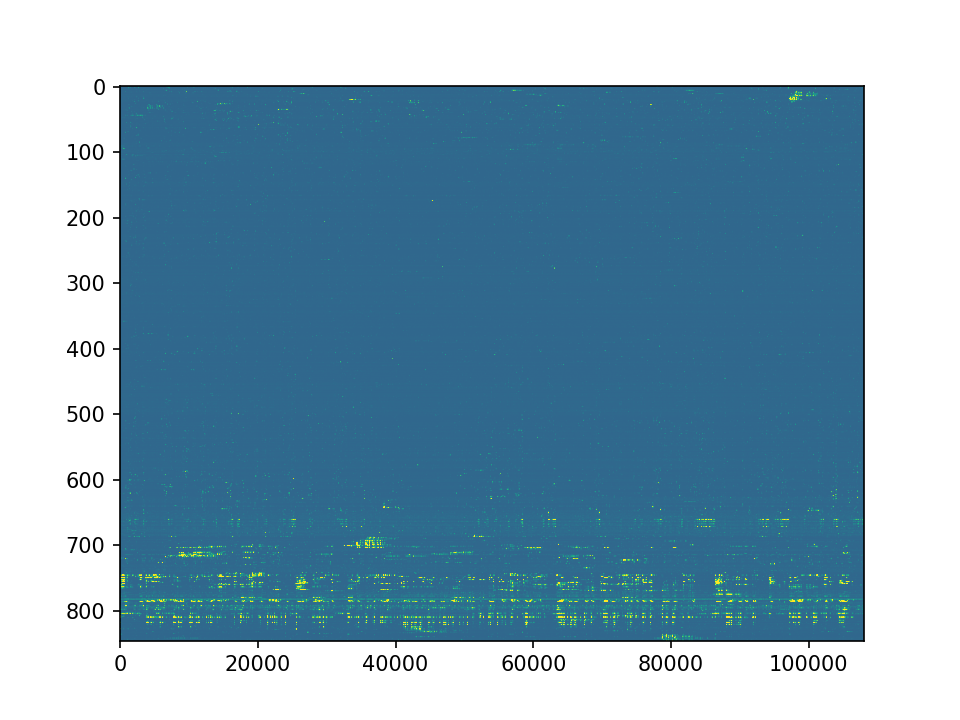

In [21]:
%matplotlib notebook

plt.figure()
# plt.imshow(dFoF_sub_ptile[rmap.isort], aspect='auto', vmax=1)
# plt.imshow(np.clip(scipy.stats.zscore(dFoF_sub_ptile, axis=1), -1,1)[rmap.isort], aspect='auto', vmax=1)
plt.imshow(dFoF_sub_ptile_clipped[rmap.isort], aspect='auto', vmin=-0.2, vmax=1)
# plt.imshow(scipy.stats.zscore(dFoF)[rmap.isort], aspect='auto', vmin=-0.1, vmax=1)

# Run SPCA

In [22]:
# neural_data_toUse =dFoF / np.std(dFoF,axis=1,keepdims=True)
# neural_data_toUse = (dFoF_sub_ptile / np.std(dFoF_sub_ptile,axis=1,keepdims=True))[:,indices_cropped]
neural_data_toUse = (dFoF_sub_ptile_clipped / np.std(dFoF_sub_ptile_clipped,axis=1,keepdims=True))

In [ ]:
# neural_data_toUse = (dFoF_sub_ptile / np.std(dFoF_sub_ptile,axis=1,keepdims=True))
# neural_data_toUse = similarity.orthogonalize(neural_data_toUse.T, traces_toOrth)[0].T

# neural_data_toUse = np.clip(neural_data_toUse, a_min=0, a_max=None)

#### Orthogonalize avgVector out


In [23]:
# avgVector in neural_data_toUse space is supposed to be all-ones vector, but just to make sure...
avgVector = neural_data_toUse.std(1)[np.newaxis,:]
neural_data_toUse_ortho = neural_data_toUse - (avgVector.T * ((avgVector @ neural_data_toUse) / (avgVector @ avgVector.T)))
neural_data_toUse_ortho_centered = neural_data_toUse_ortho - neural_data_toUse_ortho.mean(1, keepdims=True)

In [56]:
neural_data_toUse_ortho.shape

(846, 108000)

<IPython.core.display.Javascript object>


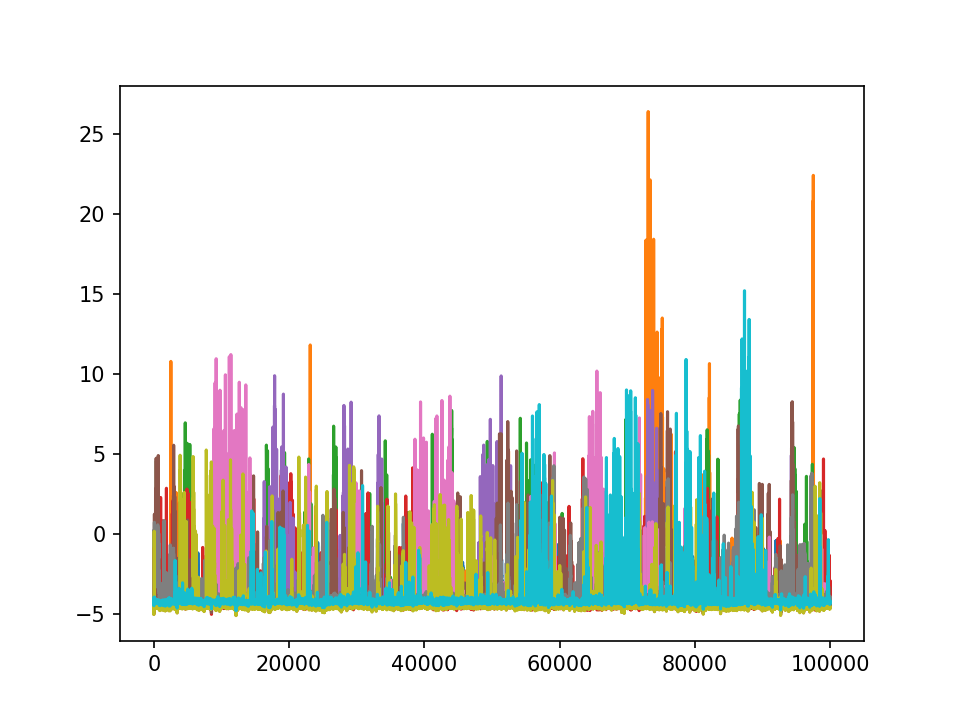

In [61]:
plt.figure()
for ii in range(10):
    plt.plot(neural_data_toUse_ortho[ii,:100000])

In [24]:
# Roll a dice and wish for luck
rank = 10

In [25]:
# Initialization method: np.linalg.svd(X, full_matrices=False)
SPCA = sklearn.decomposition.SparsePCA(n_components=rank,
                                             alpha=1,
                                             ridge_alpha=0.01,
                                             max_iter=100,
                                             tol=1e-08,
                                             method='lars',
                                             n_jobs=-1,
                                             U_init=None,
                                             V_init=None,
                                             verbose=True,
                                             random_state=None)

factors_SPCA = SPCA.fit_transform(neural_data_toUse_ortho_centered.T)

[dict_learning] ....................................................................................................

In [73]:
# Initialization method: Manual PCA
PCA = sklearn.decomposition.PCA(n_components=rank,
                               copy=True,
                               whiten=False,
                               svd_solver='auto',
                               tol=0.0,
                               iterated_power='auto',
                               n_oversamples=10,
                               power_iteration_normalizer='auto',
                               random_state=None)

U_init = PCA.fit_transform(neural_data_toUse_ortho_centered.T)
V_init = PCA.components_

SPCA = sklearn.decomposition.SparsePCA(n_components=rank,
                                             alpha=1,
                                             ridge_alpha=0.01,
                                             max_iter=100,
                                             tol=1e-08,
                                             method='lars',
                                             n_jobs=-1,
                                             U_init=U_init,
                                             V_init=V_init,
                                             verbose=True,
                                             random_state=None)

factors_SPCA = SPCA.fit_transform(neural_data_toUse_ortho_centered.T)

[dict_learning] ....................................................................................................

In [74]:
factors_neuron_SPCA = SPCA.components_.T
factors_temporal_SPCA = factors_SPCA.T

# Run Regression

In [75]:
indices_to_use = np.arange(int(Fs*60*10),neural_data_toUse.shape[1])
## z-score SPCA  temporal factors
factors_temporal_SPCA_zscore = scipy.stats.zscore(factors_temporal_SPCA[:,indices_to_use],axis=1)

In [80]:
## z-score neural data ORTHOGONAL to avgVector
neural_data_toUse_zscore = welford_moving_2D.make_rollingZScore(np.array(neural_data_toUse_ortho).T, win_roll=int(Fs*60*10)).T
neural_data_toUse_zscore = neural_data_toUse_zscore[:,indices_to_use]

100%|██████████| 108000/108000 [00:18<00:00, 5774.92it/s]
/n/data1/hms/neurobio/sabatini/gyu/github_clone/basic_neural_processing_modules/bnpm/welford_moving_2D.py:142: RuntimeWarning: divide by zero encountered in divide
  X_zscore_roll = (list_of_values - X_mean_rolling)/np.sqrt(X_var_rolling)
/n/data1/hms/neurobio/sabatini/gyu/github_clone/basic_neural_processing_modules/bnpm/welford_moving_2D.py:142: RuntimeWarning: invalid value encountered in divide
  X_zscore_roll = (list_of_values - X_mean_rolling)/np.sqrt(X_var_rolling)


In [66]:
neural_data_toUse_zscore = scipy.stats.zscore(np.array(neural_data_toUse_ortho[:,indices_to_use]), axis=1)

<IPython.core.display.Javascript object>


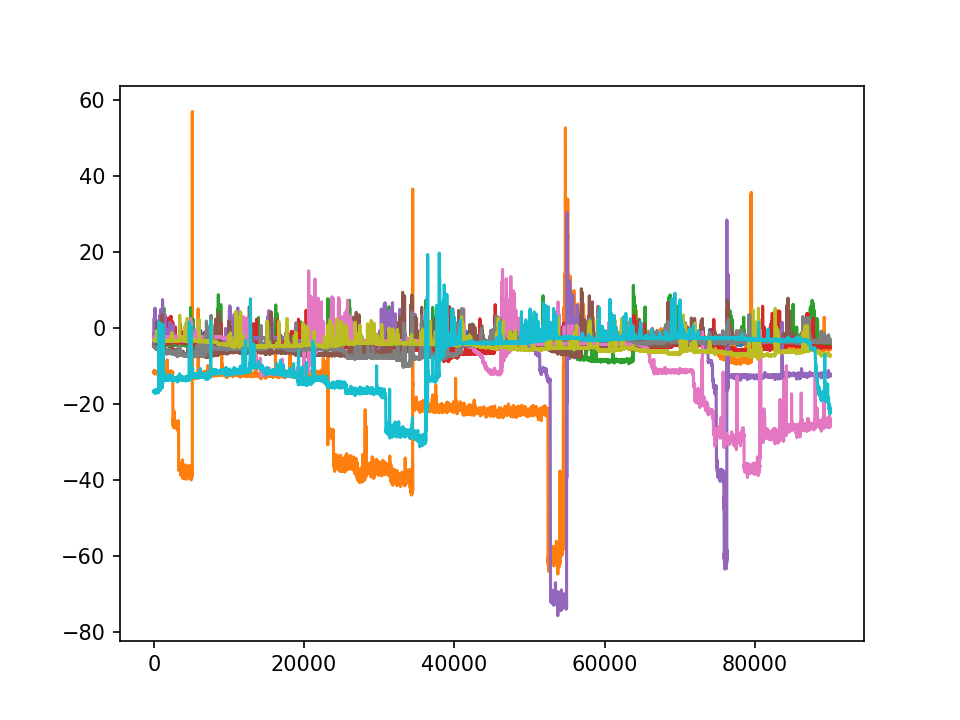

In [84]:
plt.figure()
for ii in range(10):
    plt.plot(neural_data_toUse_zscore[ii,:100000])

In [52]:
neural_data_toUse_zscore = np.nan_to_num(neural_data_toUse_zscore, nan=0)

In [53]:
neural_data_toUse_zscore.shape

(846, 90000)

<IPython.core.display.Javascript object>


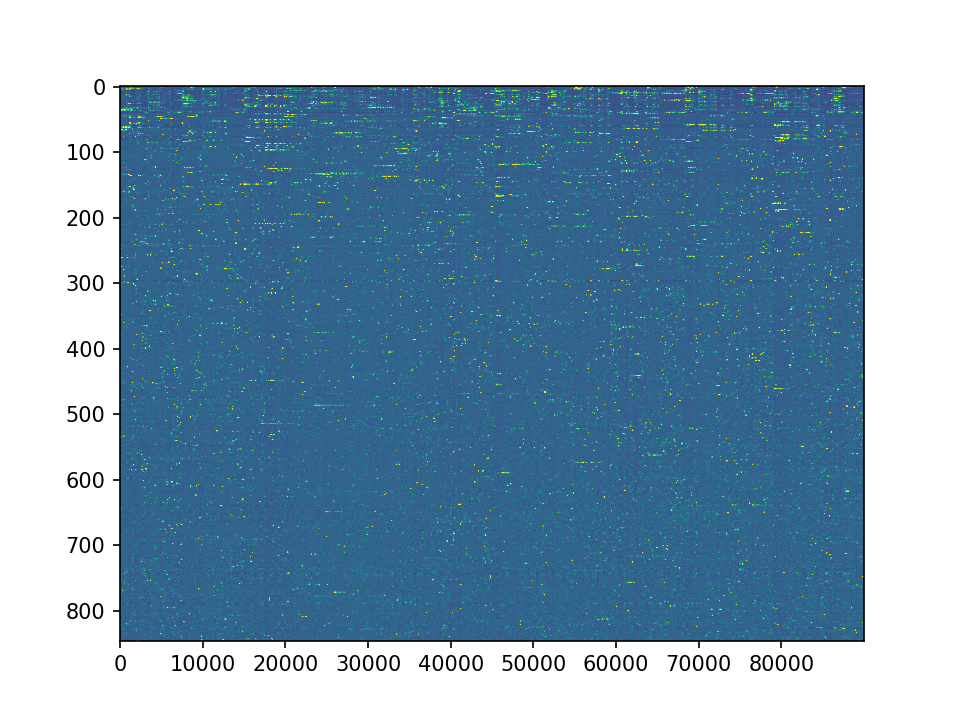

In [69]:
%matplotlib notebook

plt.figure()
# plt.imshow(dFoF_sub_ptile[rmap.isort], aspect='auto', vmax=1)
plt.imshow(
    neural_data_toUse_zscore,
    aspect='auto',
    vmin=-1, 
    vmax=2,
)

In [81]:
# OLS Regression
theta, factors_temporal_regression, bias = linear_regression.OLS(neural_data_toUse_zscore.T, factors_temporal_SPCA_zscore.T)
factors_temporal_regression = factors_temporal_regression.T

In [ ]:
# # Ridge Regression
# theta, factors_temporal_regression, bias = linear_regression.Ridge(neural_data_toUse_zscore.T, factors_temporal_SPCA_zscore.T, lam=100000)
# factors_temporal_regression = factors_temporal_regression.T

In [ ]:
# # ElasticNet Regression
# elr = sklearn.linear_model.ElasticNet(
#     alpha=0.1,
#     l1_ratio=0.05, 
#     fit_intercept=False,
# #     normalize='deprecated',
# #     precompute=False,
#     max_iter=1000, 
# #     copy_X=True, 
#     tol=0.0001,
# #     warm_start=False, 
#     positive=False,
#     random_state=42, 
#     selection='cyclic',
# #     verbose=True,
# )
# elr.fit(neural_data_toUse_zscore.T, factors_temporal_SPCA_zscore.T)

# theta = elr.coef_.T
# factors_temporal_regression = elr.predict(neural_data_toUse_zscore.T).T

<IPython.core.display.Javascript object>


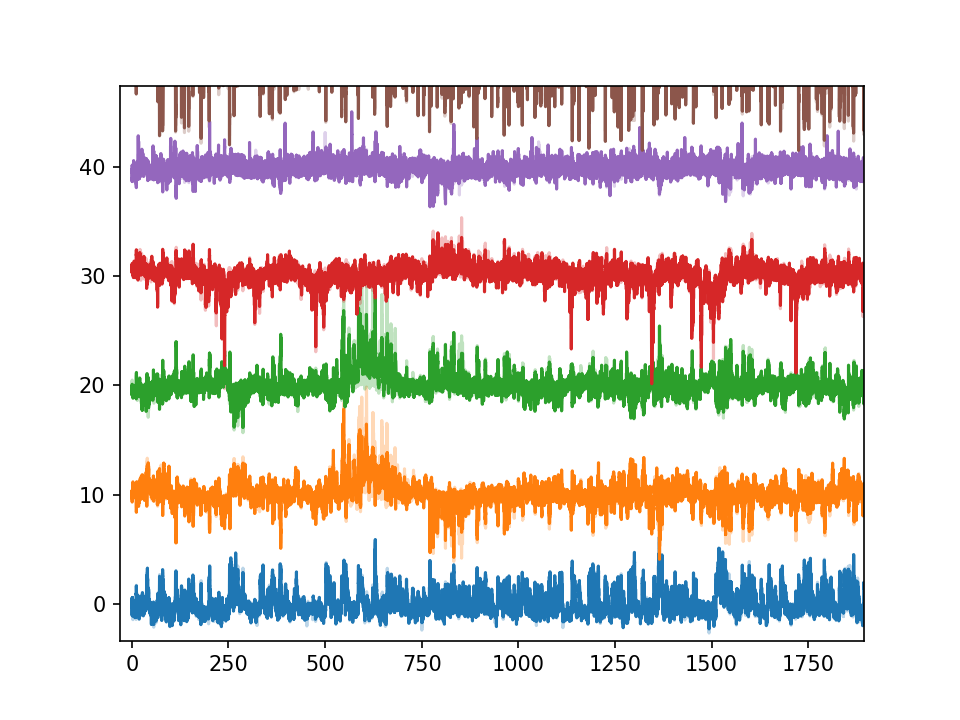

In [82]:
plt.figure()
plt.plot(np.arange(factors_temporal_SPCA_zscore.shape[1])/Fs,  factors_temporal_SPCA_zscore.T + 10*np.arange(rank)[None,:], alpha=0.3);
plt.gca().set_prop_cycle(None)
plt.plot(np.arange(factors_temporal_regression.shape[1])/Fs,  factors_temporal_regression.T + 10*np.arange(rank)[None,:]);

In [83]:
similarity.EV(factors_temporal_SPCA_zscore.T, factors_temporal_regression.T)

(array([0.96659165, 0.86275462, 0.82152177, 0.9089541 , 0.7074208 ,
        0.95263384, 0.80433576, 0.89790319, 0.83675498, 0.8770894 ]),
 0.8635960112765675,
 0.8635960112765675)

In [85]:
# Filter based on Explained Variance
# If we can't predict a factor well, don't keep it
ev_threshold = 0.7
_, pairwise, evr_weighted, _ = similarity.pairwise_orthogonalization(factors_temporal_regression.T.astype(np.float32), factors_temporal_SPCA_zscore.T.astype(np.float32))
factors_temporal_tokeep = factors_temporal_regression[pairwise > ev_threshold]

rank_good = (pairwise > ev_threshold).sum()
print(f'Rank above 0.7 EV: {rank_good}')

Rank above 0.7 EV: 10


In [86]:
pairwise

array([0.96659225, 0.8627518 , 0.82152164, 0.9089532 , 0.7074231 ,
       0.95263296, 0.8043345 , 0.8979029 , 0.83675575, 0.8770894 ],
      dtype=float32)

In [87]:
# get evr for original? or zscored one?
_, _, evrs = get_highest_evr_var(neural_data_toUse_ortho[:,indices_to_use].T, factors_temporal_tokeep,  np.ones(rank, bool))
# _, _, evrs = get_highest_evr_var(neural_data_toUse_zscore[:,indices_to_use].T, factors_temporal_tokeep,  np.ones(rank, bool))

<IPython.core.display.Javascript object>


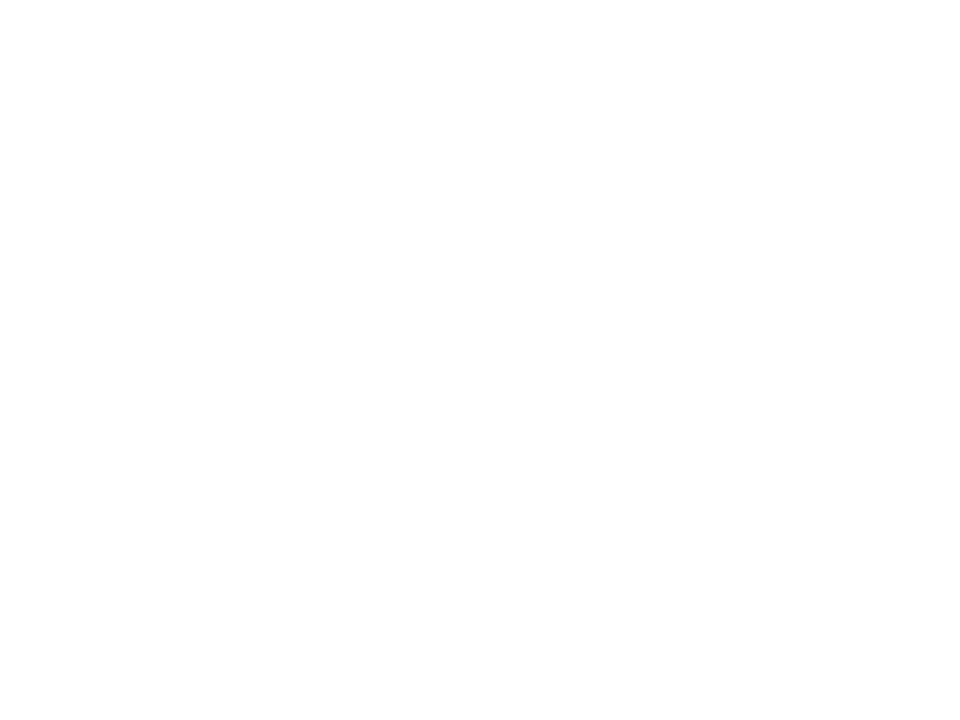

In [88]:
%matplotlib notebook
plt.figure()
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs,  factors_temporal_SPCA_zscore[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank_good),alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs,  factors_temporal_tokeep[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank_good));

<IPython.core.display.Javascript object>


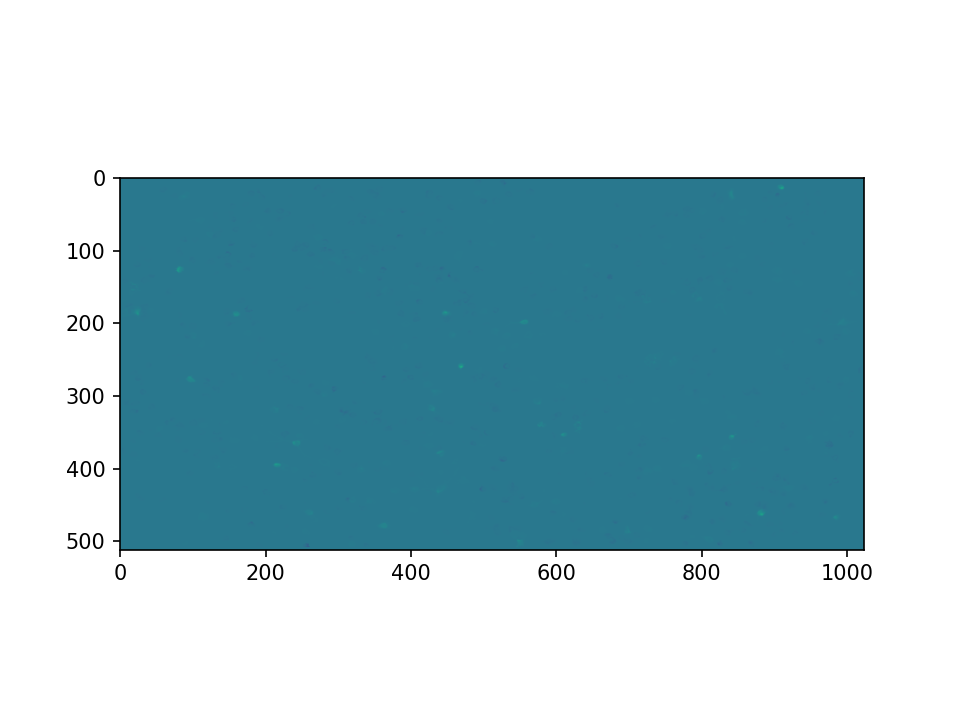

interactive(children=(IntSlider(value=0, description='i_frame', max=9), Output()), _dom_classes=('widget-inter…

In [89]:
weights = theta[:,np.argsort(evrs)[::-1]]
# weights = theta
sf_weights = np.einsum('ij,ikl->jkl', weights,sf[iscell])

%matplotlib notebook
display_toggle_image_stack(
    sf_weights, 
    clim=[sf_weights.min(), sf_weights.max()]
)

# Run temporal factor Orthogonalization

In [90]:
factors_orth = copy.deepcopy(factors_temporal_tokeep)
num_factors = rank_good
hits = np.ones(num_factors, bool)
for i in range(num_factors-1):
    ind_to_orthogonalize, factor_to_orthogonalize, evrs = get_highest_evr_var(neural_data_toUse_zscore.T, factors_orth, hits)
    print(f'Factor at {ind_to_orthogonalize} index explains {evrs[ind_to_orthogonalize]} of the variance in neural data')
    hits[ind_to_orthogonalize] = False
    factors_orth[hits] = np.transpose(orthogonalize_simple(factors_orth[hits].T, factor_to_orthogonalize))

Factor at 6 index explains 0.028954134398400333 of the variance in neural data
Factor at 4 index explains 0.021551725209815742 of the variance in neural data
Factor at 3 index explains 0.012959365888358665 of the variance in neural data
Factor at 2 index explains 0.010515710830493075 of the variance in neural data
Factor at 1 index explains 0.008003995310541412 of the variance in neural data
Factor at 5 index explains 0.005551779419703529 of the variance in neural data
Factor at 9 index explains 0.004234368775908881 of the variance in neural data
Factor at 0 index explains 0.0025361491308315554 of the variance in neural data
Factor at 7 index explains 0.0023868766072808745 of the variance in neural data


<IPython.core.display.Javascript object>


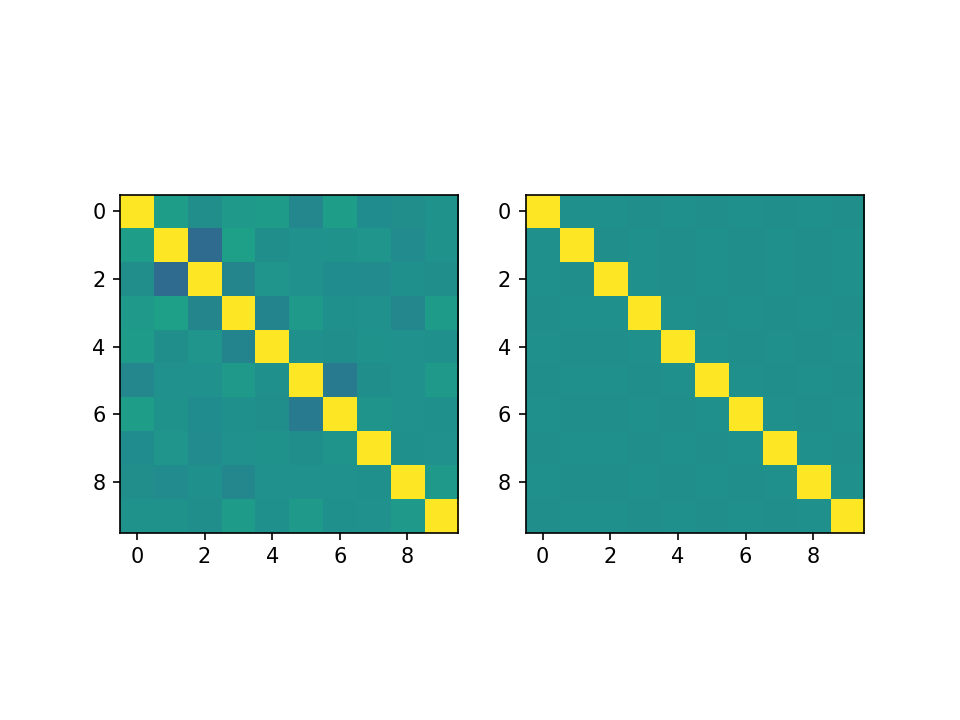

In [91]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.corrcoef(factors_temporal_tokeep),vmin=-1)
ax2.imshow(np.corrcoef(factors_orth),vmin=-1)

In [92]:
_, _, evrs = get_highest_evr_var(neural_data_toUse_zscore.T, factors_orth,  np.ones(num_factors, bool))

In [93]:
np.sort(evrs)

array([0.00170544, 0.00238688, 0.00253615, 0.00423437, 0.00555178,
       0.008004  , 0.01051571, 0.01295937, 0.02155173, 0.02895413])

# Run Regression Pt 2

In [94]:
# OLS Regression
theta, factors_orth_regression, bias = linear_regression.OLS(neural_data_toUse_zscore.T, factors_orth.T)
factors_orth_regression = factors_orth_regression.T

In [95]:
_, _, evrs = get_highest_evr_var(neural_data_toUse[:,indices_to_use].T, factors_orth,  np.ones(num_factors, bool))

<IPython.core.display.Javascript object>


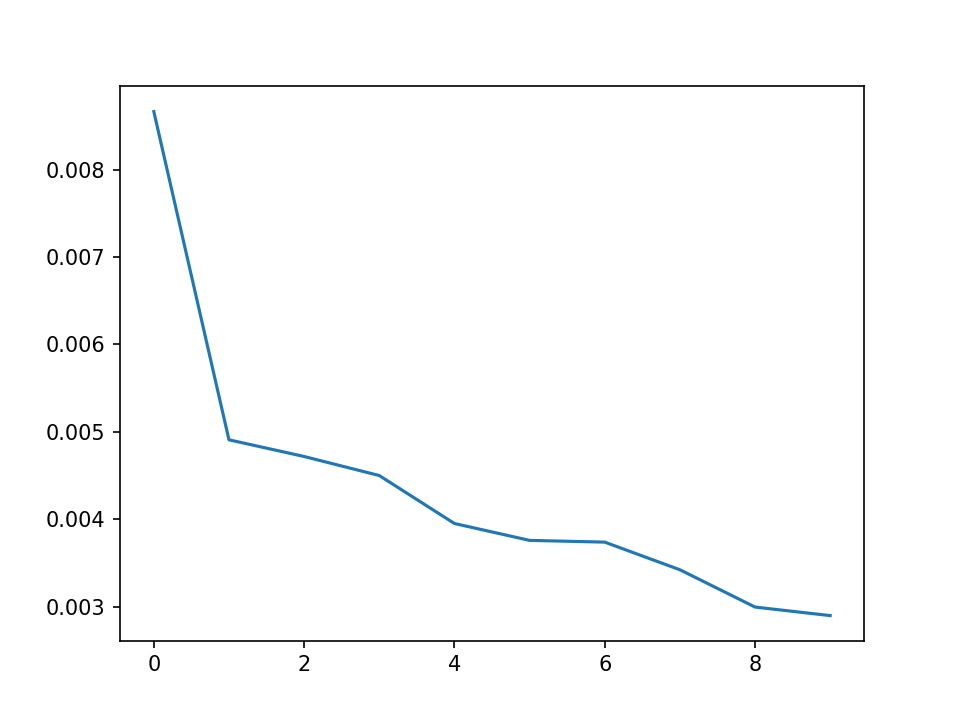

In [96]:
plt.figure()
plt.plot(np.sort(evrs)[::-1])

# Visualize

In [97]:
%matplotlib notebook
plt.figure()
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, factors_temporal_tokeep[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank_good),alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, factors_orth_regression[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank_good))

<IPython.core.display.Javascript object>

In [ ]:
weights = theta[:,np.argsort(evrs)[::-1]]
sf_weights = np.einsum('ij,ikl->jkl', weights,sf[iscell])

factors_orth_regression_sorted = factors_orth_regression[np.argsort(evrs)[::-1]]

%matplotlib notebook
display_toggle_image_stack(sf_weights)

In [ ]:
weights_zeroSum = weights - weights.mean(0)

In [ ]:
plt.figure()
plt.imshow(neural_data_toUse_zscore, aspect='auto', vmax=4)

In [ ]:
%matplotlib notebook
plt.figure()
plt.imshow(theta[:,:],aspect='auto', interpolation='none')

In [ ]:
%matplotlib notebook
plt.figure()
plt.imshow(weights_zeroSum[:,:],aspect='auto', interpolation='none')

# Save it all

In [ ]:
factor_to_use = 0 # 0-indexed
weights = theta[:,np.argsort(evrs)[::-1]]

weights_day0 = {
    "weights": weights_zeroSum[:,factor_to_use],
    "weights_all" : weights_zeroSum,
    "factors_neural": weights
    "iscell_custom": iscell,
    "factor_to_use": factor_to_use,
    "sf_weights": sf_weights,
#     "factors_temporal": factors_temporal_tokeep,
    "factors_temporal": factors_orth_regression_sorted,
}


F = scipy.io.savemat(path_save.with_suffix('.mat') , weights_day0)

np.save(path_save.with_suffix('.npy') , weights_day0)

# Load in old outputs

In [ ]:
import numpy as np

In [ ]:
data = np.load(r'D:/RH_local/data/BMI_cage_1511_4/mouse_1511L/20230111/analysis_data/weights_day0.npy', allow_pickle=True)[()]

In [ ]:
data.keys()

In [ ]:
import bnpm.plotting_helpers

In [ ]:
# weights = theta[:,np.argsort(evrs)[::-1]]
# sf_weights = np.einsum('ij,ikl->jkl', data['weights_all'], sf[data['iscell_custom']])

%matplotlib notebook
bnpm.plotting_helpers.display_toggle_image_stack(data['sf_weights'])